In [3]:
# ここを変えると使用するデータセットを変えられる
dataset = 'digits' # digits', 'speech', 'birds', 'drums', 'piano'の中から一つ

# GPUが動いているか確かめる
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
if len(get_available_gpus()) == 0:
  for i in range(4):
    print('WARNING: Not running on a GPU! See above for faster generation')

# モデルのダウンロード
if dataset == 'digits':
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09_infer.meta -O infer.meta
elif dataset == 'speech':
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit_infer.meta -O infer.meta
elif dataset == 'birds':
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds_infer.meta -O infer.meta
elif dataset == 'drums':
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums_infer.meta -O infer.meta
elif dataset == 'piano':
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano_infer.meta -O infer.meta
else:
  raise NotImplementedError()

# モデルのロード
import tensorflow as tf

tf.reset_default_graph()
saver = tf.train.import_meta_graph('infer.meta')
graph = tf.get_default_graph()
sess = tf.InteractiveSession()
saver.restore(sess, 'model.ckpt')

--2019-12-24 08:33:47--  https://s3.amazonaws.com/wavegan-v1/models/sc09.ckpt.index
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.171.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.171.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681 [binary/octet-stream]
Saving to: ‘model.ckpt.index’

model.ckpt.index    100%[===================>]     681  --.-KB/s    in 0s      

2019-12-24 08:33:48 (55.4 MB/s) - ‘model.ckpt.index’ saved [681/681]

--2019-12-24 08:33:50--  https://s3.amazonaws.com/wavegan-v1/models/sc09.ckpt.data-00000-of-00001
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76261388 (73M) [application/x-www-form-urlencoded]
Saving to: ‘model.ckpt.data-00000-of-00001’

model.ckpt.data-000 100%[===================>]  72.73M  13.5MB/s    in 6.5s    

2019-12-24 08:33:57 (11.2 MB/s)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Finished! (Took 6.61217474937439 seconds)
--------------------------------------------------------------------------------
Example 1


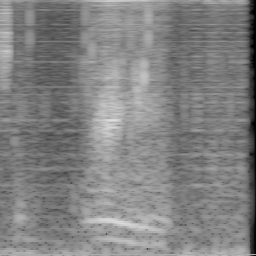

--------------------------------------------------------------------------------
Example 2


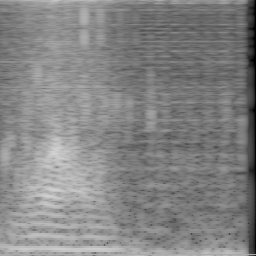

--------------------------------------------------------------------------------
Example 3


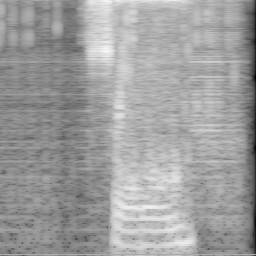

--------------------------------------------------------------------------------
Example 4


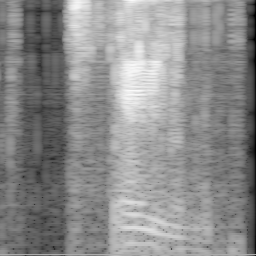

In [4]:
# 音の生成と表示

# ここを変えると生成、表示する例の数を変えられる
ngenerate = 64
ndisplay = 4

import numpy as np
import PIL.Image
from IPython.display import display, Audio
import time as time

# サンプルの存在的なベクトル
_z = (np.random.rand(ngenerate, 100) * 2.) - 1.

# 生成
z = graph.get_tensor_by_name('z:0')
G_z = graph.get_tensor_by_name('G_z:0')[:, :, 0]
G_z_spec = graph.get_tensor_by_name('G_z_spec:0')

start = time.time()
_G_z, _G_z_spec = sess.run([G_z, G_z_spec], {z: _z})
print('Finished! (Took {} seconds)'.format(time.time() - start))

for i in range(ndisplay):
  print('-' * 80)
  print('Example {}'.format(i+1))
  display(PIL.Image.fromarray(_G_z_spec[i]))
  display(Audio(_G_z[i], rate=16000))

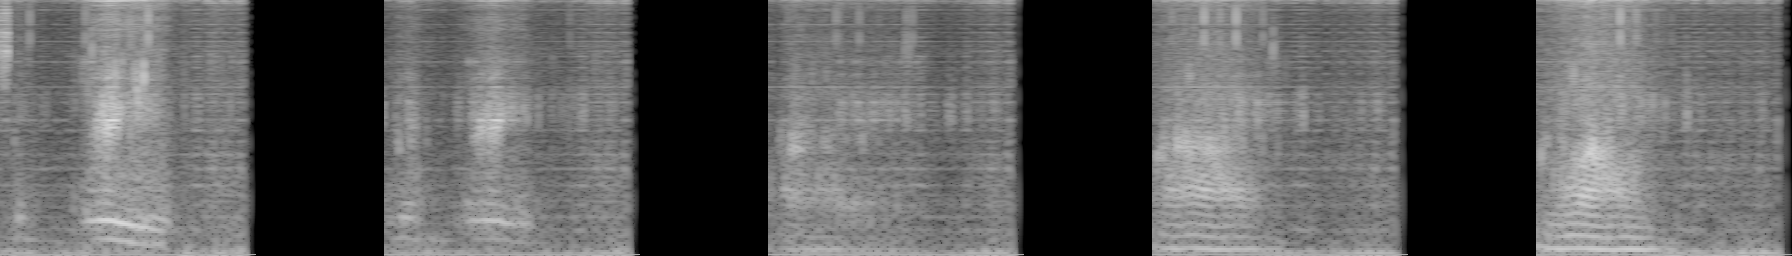

In [5]:
# 潜在空間で補間する

# ここを変えると、上のセルからの例のIDを変えられる
interp_a = 0
interp_b = 1

# ここを変えると、中間体の数を変えられる
interp_n = 3

# 潜在コードの補間
_za, _zb = _z[interp_a], _z[interp_b]
_z_interp = []
for i in range(interp_n + 2):
  a = i / float(interp_n + 1)
  _z_interp.append((1-a) * _za + a * _zb)

# 連結して視覚化を容易にする
flat_pad = graph.get_tensor_by_name('flat_pad:0')
G_z_flat = graph.get_tensor_by_name('G_z_flat:0')[:, 0]
G_z_spec_padded = tf.pad(G_z_spec, [[0, 0], [0, 0], [0, 128]])
G_z_spec_padded = tf.transpose(G_z_spec_padded, [0, 2, 1])
G_z_spec_flat = tf.reshape(G_z_spec_padded, [-1, 256])
G_z_spec_flat = tf.transpose(G_z_spec_flat, [1, 0])[:, :-128]

# 生成
_G_z_flat, _G_z_spec = sess.run([G_z_flat, G_z_spec_flat], {z: _z_interp, flat_pad: 8192})

# 表示
display(PIL.Image.fromarray(_G_z_spec))
display(Audio(_G_z_flat, rate=16000))